In [570]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.stats as s
import astropy.units as u
import astropy.constants as c
import astropy.visualization.wcsaxes as v
import scipy.interpolate as interp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import matplotlib.offsetbox
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from reproject import reproject_interp
import pandas as pd
import astropy.coordinates as coord

from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.stats import sigma_clip
from photutils.aperture import SkyCircularAperture, CircularAperture, ApertureStats

from spectral_cube import SpectralCube
from radio_beam import beam
from regions import Regions
from scipy import optimize

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
})

In [571]:
#make sure you drop degenerate axes in M0 maps using carta
# source_name='Oph_12'
# source_name='Oph_26'
# source_name='Oph_27'
# source_name='Oph_29'
# source_name='Oph_31'
source_name='Oph_34'
# source_name='Oph_39'

path = '/net/vdesk/data2/bach1/ballieux/master_project_2/data/low_mass_data/'+source_name+'/' # Path to the data
B3_red_name='M0_maps/CO10_M0_red'      #M0 map of the CO 1-0 line, band 3, redshifted
B6_red_name = 'M0_maps/CO21_M0_red'    #M0 map of the CO 2-1 line, band 6, redshifted
B7_red_name = 'M0_maps/CO32_M0_red'    #M0 map of the CO 3-2 line, band 7, redshifted
B3_blue_name='M0_maps/CO10_M0_blue'    #M0 map of the CO1-0 line, band 3, blueshifted
B6_blue_name = 'M0_maps/CO21_M0_blue'    #M0 map of the CO 2-1 line, band 6, blueshifted
B7_blue_name = 'M0_maps/CO32_M0_blue'    #M0 map of the CO 3-2 line, band 7, blueshifted

if source_name == 'Oph_12':
    red_velrange='5.1;10.5'
    blue_velrange = '-3.2;1.9'
if source_name == 'Oph_26':
    red_velrange='4.3;11.8'
    blue_velrange = '-6.3;1.9'
if source_name == 'Oph_27':
    red_velrange='5.9;11'
    blue_velrange = '-10;1.0'
if source_name == 'Oph_29':
    red_velrange='5;8'
    blue_velrange = '-6;1.25'
if source_name == 'Oph_31':
    red_velrange='4.5;9'
    blue_velrange = '-1;1'
if source_name == 'Oph_34':
    red_velrange='3;7'
    blue_velrange = '-9;0.9'
if source_name == 'Oph_39':
    red_velrange='4.5;11'
    blue_velrange = '-5;2.4'

d = 140 * u.pc
e_d = 4 * u.pc
 
#Open the fits files
hdu_B3_red = fits.open(path+B3_red_name)
hdu_B6_red = fits.open(path+B6_red_name)
hdu_B7_red = fits.open(path+B7_red_name)
hdu_B3_blue = fits.open(path+B3_blue_name)
hdu_B6_blue = fits.open(path+B6_blue_name)
hdu_B7_blue = fits.open(path+B7_blue_name)

# Always manually check the beam is exactly the same for both maps, and check unit of major axis. They should be the same but check
beam_major = hdu_B7_red[0].header['BMAJ']*3600 *u.arcsec # Beam major axis size in arcseconds
beam_minor = hdu_B7_blue[0].header['BMIN']*3600 *u.arcsec # Beam minor axis size in arcseconds
beam_pa = hdu_B7_red[0].header['BPA']*u.deg  # Beam position angle in degrees


#get the pixel size form the header
if (source_name == 'Oph_12') or (source_name == 'Oph_26') or (source_name == 'Oph_27') or (source_name == 'Oph_29') or (source_name == 'Oph_31') or (source_name == 'Oph_39'):
    pixel_size=0.49 *u.arcsec #From CO32
if source_name == 'Oph_34':
    pixel_size=0.34 *u.arcsec #From CO10

#The WCS object is used to convert between pixel and world coordinates
wcs_B3_red = WCS(hdu_B3_red[0].header)
wcs_B6_red = WCS(hdu_B6_red[0].header)
wcs_B7_red = WCS(hdu_B7_red[0].header)
wcs_B3_blue = WCS(hdu_B3_blue[0].header)
wcs_B6_blue = WCS(hdu_B6_blue[0].header)
wcs_B7_blue = WCS(hdu_B7_blue[0].header)

#Two of the images needs to be regridded, this can be done because both are well sampled
if source_name == 'Oph_12' or source_name == 'Oph_26' or source_name == 'Oph_27' or source_name == 'Oph_29' or source_name == 'Oph_31' or source_name == 'Oph_39':
    B7_red = hdu_B7_red[0].data *u.Jy*u.km/u.s
    B3_red, footprint_red_3 = reproject_interp(hdu_B3_red[0], hdu_B7_red[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B6_red, footprint_red_6 = reproject_interp(hdu_B6_red[0], hdu_B7_red[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B7_blue = hdu_B7_blue[0].data *u.Jy*u.km/u.s
    B3_blue, footprint_blue_3 = reproject_interp(hdu_B3_blue[0], hdu_B7_blue[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B6_blue, footprint_blue_6 = reproject_interp(hdu_B6_blue[0], hdu_B7_blue[0].header) *u.Jy*u.km/u.s  #regridded to CO32

if source_name == 'Oph_34': #This is the different one!
    B3_red = hdu_B3_red[0].data *u.Jy*u.km/u.s
    B6_red, footprint_red_6 = reproject_interp(hdu_B6_red[0], hdu_B3_red[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B7_red, footprint_red_7 = reproject_interp(hdu_B7_red[0], hdu_B3_red[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B3_blue = hdu_B3_blue[0].data *u.Jy*u.km/u.s
    B6_blue, footprint_blue_6 = reproject_interp(hdu_B6_blue[0], hdu_B3_blue[0].header) *u.Jy*u.km/u.s  #regridded to CO32
    B7_blue, footprint_blue_7 = reproject_interp(hdu_B7_blue[0], hdu_B3_blue[0].header) *u.Jy*u.km/u.s  #regridded to CO32

#RMS calculation
B3_red_rms_name = B3_red_name+'_rms'    #empty region of M0 map of the CO 2-1 line, band 3, shape does not matter
B6_red_rms_name = B6_red_name+'_rms'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter
B7_red_rms_name = B7_red_name+'_rms'   #empty region of M0 map of the CO 3-2 line, band 7, shape does not matter
B3_blue_rms_name = B3_blue_name+'_rms'    #empty region of M0 map of the CO 2-1 line, band 3, shape does not matter
B6_blue_rms_name = B6_blue_name+'_rms'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter
B7_blue_rms_name = B7_blue_name+'_rms'   #empty region of M0 map of the CO 3-2 line, band 7, shape does not matter

# #This is now just an empty region of the map to get rms level. Later convolve with 10%
hdu_B3_red_err = fits.open(path+B3_red_rms_name)
hdu_B6_red_err = fits.open(path+B6_red_rms_name)
hdu_B7_red_err = fits.open(path+B7_red_rms_name)
hdu_B3_blue_err = fits.open(path+B3_blue_rms_name)
hdu_B6_blue_err = fits.open(path+B6_blue_rms_name)
hdu_B7_blue_err = fits.open(path+B7_blue_rms_name)

#Here we take the not-nan values to calculate the rms. The other images do still contain nan values
B3_red_rms= np.sqrt(np.mean(np.square(hdu_B3_red_err[0].data[hdu_B3_red_err[0].data >0]) ))*u.Jy*u.km/u.s
B6_red_rms = np.sqrt(np.mean(np.square(hdu_B6_red_err[0].data[hdu_B6_red_err[0].data >0]) ))*u.Jy*u.km/u.s
B7_red_rms = np.sqrt(np.mean(np.square(hdu_B7_red_err[0].data[hdu_B7_red_err[0].data >0]) ))*u.Jy*u.km/u.s
B3_blue_rms = np.sqrt(np.mean(np.square(hdu_B3_blue_err[0].data[hdu_B3_blue_err[0].data >0]) ))*u.Jy*u.km/u.s
B6_blue_rms = np.sqrt(np.mean(np.square(hdu_B6_blue_err[0].data[hdu_B6_blue_err[0].data >0]) ))*u.Jy*u.km/u.s
B7_blue_rms = np.sqrt(np.mean(np.square(hdu_B7_blue_err[0].data[hdu_B7_blue_err[0].data >0]) ))*u.Jy*u.km/u.s
#Also convolution with 10% systematic error

systematic_error = 0.1 # 10% systematic error
B3_red_err = np.sqrt(np.square(B3_red_rms) + np.square(systematic_error* B3_red))
B6_red_err = np.sqrt(np.square(B6_red_rms) + np.square(systematic_error* B6_red))
B7_red_err = np.sqrt(np.square(B7_red_rms) + np.square(systematic_error* B7_red))
B3_blue_err = np.sqrt(np.square(B3_blue_rms) + np.square(systematic_error* B3_blue))
B6_blue_err = np.sqrt(np.square(B6_blue_rms) + np.square(systematic_error* B6_blue))
B7_blue_err = np.sqrt(np.square(B7_blue_rms) + np.square(systematic_error* B7_blue))

hdu_B3_red.close()
hdu_B6_red.close()
hdu_B7_red.close()
hdu_B3_red_err.close()
hdu_B6_red_err.close()
hdu_B7_red_err.close()
hdu_B3_blue.close()
hdu_B6_blue.close()
hdu_B7_blue.close()
hdu_B3_blue_err.close()
hdu_B6_blue_err.close()
hdu_B7_blue_err.close()

twomass_cores_name='/net/vdesk/data2/bach1/ballieux/master_project_2/data/low_mass_data/plotting_coordinates.csv'
hdu_twomass_cores = pd.read_csv(twomass_cores_name)
twomass_cores_RA = np.array(hdu_twomass_cores['RA_2mass'])
twomass_cores_DEC = np.array(hdu_twomass_cores['Dec_2mass'])
twomass_cores_coords = coord.SkyCoord(ra=twomass_cores_RA, dec=twomass_cores_DEC, frame='icrs', unit=(u.deg, u.deg))

In [572]:
#Determine the SNR
SNR_B3_red = B3_red/B3_red_err
SNR_B6_red = B6_red/B6_red_err
SNR_B7_red = B7_red/B7_red_err
SNR_B3_blue = B3_blue/B3_blue_err
SNR_B6_blue = B6_blue/B6_blue_err
SNR_B7_blue = B7_blue/B7_blue_err

clip = 3 # We clip at 3 sigma since Serena told Wout you need at least 3
mask_total_red = (SNR_B3_red>clip) &  (SNR_B6_red>clip) & (SNR_B7_red>clip) # just as diagnostic
mask_total_blue = (SNR_B3_blue>clip) & (SNR_B6_blue>clip) & (SNR_B7_blue>clip) # just as diagnostic

B3_red_clip = np.copy(B3_red)
B6_red_clip = np.copy(B6_red)
B7_red_clip = np.copy(B7_red)
B3_blue_clip = np.copy(B3_blue)
B6_blue_clip = np.copy(B6_blue)
B7_blue_clip = np.copy(B7_blue)

B3_red_clip[SNR_B3_red<clip] = np.nan
B6_red_clip[SNR_B6_red<clip] = np.nan
B7_red_clip[SNR_B7_red<clip] = np.nan
B3_blue_clip[SNR_B3_blue<clip] = np.nan
B6_blue_clip[SNR_B6_blue<clip] = np.nan
B7_blue_clip[SNR_B7_blue<clip] = np.nan

B3_red_clip[B3_red_clip==0] = np.nan
B6_red_clip[B6_red_clip==0] = np.nan
B7_red_clip[B7_red_clip==0] = np.nan
B3_blue_clip[B3_blue_clip==0] = np.nan
B6_blue_clip[B6_blue_clip==0] = np.nan
B7_blue_clip[B7_blue_clip==0] = np.nan


B3_red_err_clip = np.copy(B3_red_err)
B6_red_err_clip = np.copy(B6_red_err)
B7_red_err_clip = np.copy(B7_red_err)
B3_blue_err_clip = np.copy(B3_blue_err)
B6_blue_err_clip = np.copy(B6_blue_err)
B7_blue_err_clip = np.copy(B7_blue_err)

B3_red_err_clip[SNR_B3_red<clip] = np.nan
B6_red_err_clip[SNR_B6_red<clip] = np.nan
B7_red_err_clip[SNR_B7_red<clip] = np.nan
B3_blue_err_clip[SNR_B3_blue<clip] = np.nan
B6_blue_err_clip[SNR_B6_blue<clip] = np.nan
B7_blue_err_clip[SNR_B7_blue<clip] = np.nan

B3_red_err_clip[B3_red_clip==0] = np.nan
B6_red_err_clip[B6_red_clip==0] = np.nan
B7_red_err_clip[B7_red_clip==0] = np.nan
B3_blue_err_clip[B3_blue_clip==0] = np.nan
B6_blue_err_clip[B6_blue_clip==0] = np.nan
B7_blue_err_clip[B7_blue_clip==0] = np.nan

cmap = mpl.cm.get_cmap('RdBu_r')
cmap2 = mpl.cm.get_cmap('inferno')

#Set the colourscales, using max and min values of the clipped images
norm_3_red = mpl.colors.LogNorm(vmin=np.min(B3_red_clip[B3_red_clip>0]).value, vmax=np.max(B3_red_clip[B3_red_clip>0]).value)
sm_3_red = cm.ScalarMappable(norm=norm_3_red, cmap=cmap2)
norm_6_red = mpl.colors.LogNorm(vmin=np.min(B6_red_clip[B6_red_clip>0]).value, vmax=np.max(B6_red_clip[B6_red_clip>0]).value)
sm_6_red = cm.ScalarMappable(norm=norm_6_red, cmap=cmap2)
norm_7_red = mpl.colors.LogNorm(vmin=np.min(B7_red_clip[B7_red_clip>0]).value, vmax=np.max(B7_red_clip[B7_red_clip>0]).value)
sm_7_red = cm.ScalarMappable(norm=norm_7_red, cmap=cmap2)
norm_3_blue = mpl.colors.LogNorm(vmin=np.min(B3_blue_clip[B3_blue_clip>0]).value, vmax=np.max(B3_blue_clip[B3_blue_clip>0]).value)
sm_3_blue = cm.ScalarMappable(norm=norm_3_blue, cmap=cmap2)
norm_6_blue = mpl.colors.LogNorm(vmin=np.min(B6_blue_clip[B6_blue_clip>0]).value, vmax=np.max(B6_blue_clip[B6_blue_clip>0]).value)
sm_6_blue = cm.ScalarMappable(norm=norm_6_blue, cmap=cmap2)
norm_7_blue = mpl.colors.LogNorm(vmin=np.min(B7_blue_clip[B7_blue_clip>0]).value, vmax=np.max(B7_blue_clip[B7_blue_clip>0]).value)
sm_7_blue = cm.ScalarMappable(norm=norm_7_blue, cmap=cmap2)

/var/tmp/ballieux/ipykernel_3195824/2383587653.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('RdBu_r')
/var/tmp/ballieux/ipykernel_3195824/2383587653.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap('inferno')


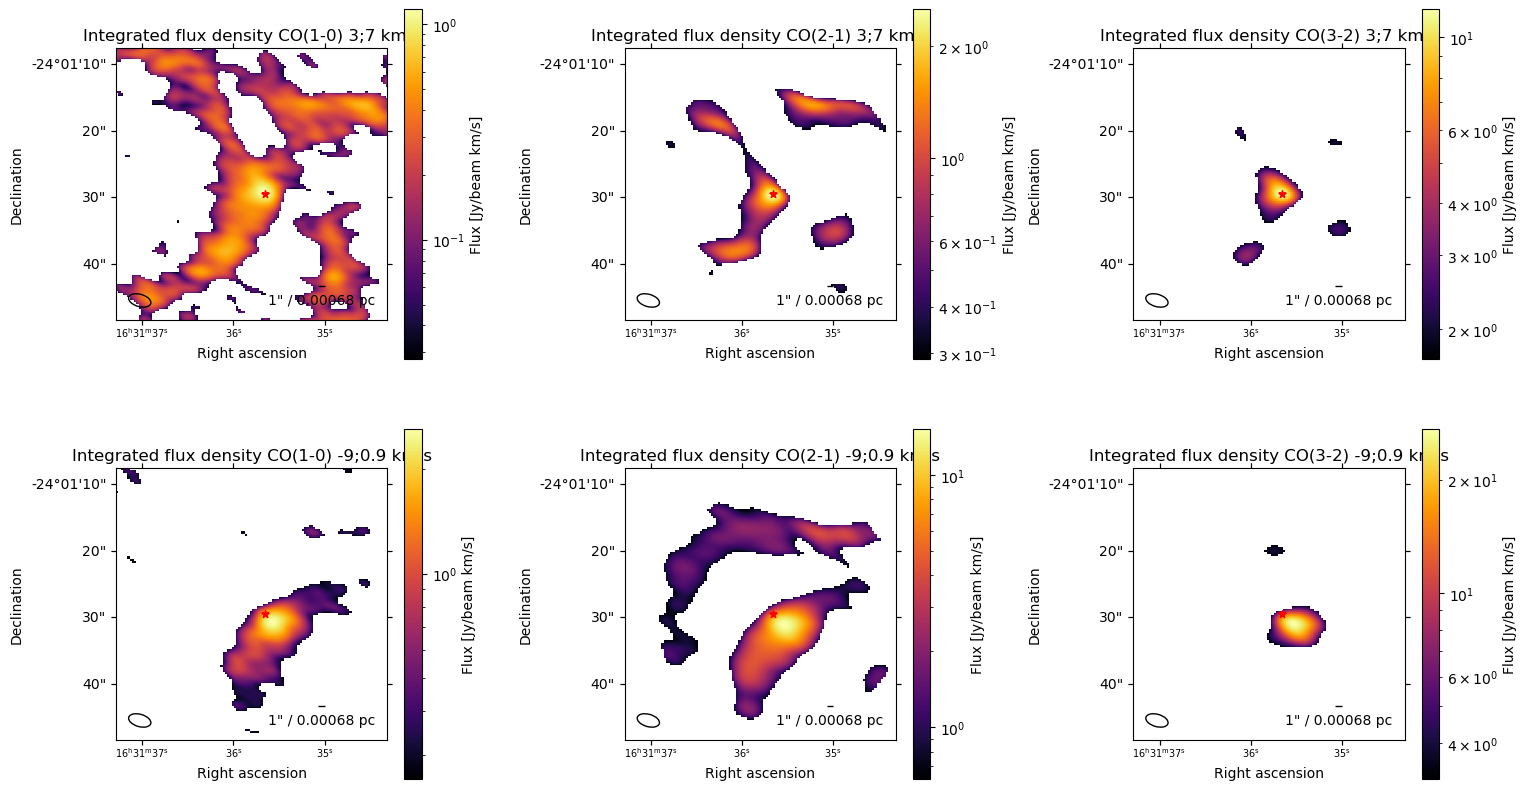

In [573]:
#here the maps are plotted
"""
ALWAYS check the wcs is the one whe reprojected to
"""
if source_name=='Oph_34':
    fig, ax = plt.subplots(2, 3, figsize=(17.5,10), subplot_kw={'projection': wcs_B3_red}) #horizontal size: 25,9.5
else:
    fig, ax = plt.subplots(2, 3, figsize=(17.5,10), subplot_kw={'projection': wcs_B7_red}) #horizontal size: 25,9.5

#CO10 redshifted
ax[0,0].imshow(B3_red_clip.value, origin='lower', cmap='inferno', norm=norm_3_red)
ax[0,0].set_title('Integrated flux density CO(1-0) ' + red_velrange + ' km/s')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
v.add_beam(ax=ax[0,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_3_red, ax=ax[0,0], label='Flux [Jy/beam km/s]')

#CO21 redshifted
ax[0,1].imshow(B6_red_clip.value, origin='lower', cmap='inferno', norm=norm_6_red)
ax[0,1].set_title('Integrated flux density CO(2-1) ' + red_velrange + ' km/s')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
v.add_beam(ax=ax[0,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_6_red, ax=ax[0,1], label='Flux [Jy/beam km/s]')

#CO32 redshifted
ax[0,2].imshow(B7_red_clip.value, origin='lower', cmap='inferno', norm=norm_7_red)
ax[0,2].set_title('Integrated flux density CO(3-2) ' + red_velrange + ' km/s')
ax[0,2].set_xlabel('Right ascension')
ax[0,2].set_ylabel('Declination')
v.add_beam(ax=ax[0,2],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0,2].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,2], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_7_red, ax=ax[0,2], label='Flux [Jy/beam km/s]')

#CO10 blueshifted
ax[1,0].imshow(B3_blue_clip.value, origin='lower', cmap='inferno', norm=norm_3_blue)
ax[1,0].set_title('Integrated flux density CO(1-0) ' + blue_velrange + ' km/s')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
v.add_beam(ax=ax[1,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_3_blue, ax=ax[1,0], label='Flux [Jy/beam km/s]')

#CO21 blueshifted
ax[1,1].imshow(B6_blue_clip.value, origin='lower', cmap='inferno', norm=norm_6_blue)
ax[1,1].set_title('Integrated flux density CO(2-1) ' + blue_velrange + ' km/s')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
v.add_beam(ax=ax[1,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_6_blue, ax=ax[1,1], label='Flux [Jy/beam km/s]')

#CO32 blueshifted
ax[1,2].imshow(B7_blue_clip.value, origin='lower', cmap='inferno', norm=norm_7_blue)
ax[1,2].set_title('Integrated flux density CO(3-2) ' + blue_velrange + ' km/s')
ax[1,2].set_xlabel('Right ascension')
ax[1,2].set_ylabel('Declination')
v.add_beam(ax=ax[1,2],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1,2].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,2], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_7_blue, ax=ax[1,2], label='Flux [Jy/beam km/s]')

ax[0,0].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[0,0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores', zorder=100)
ax[0,1].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[0,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[0,2].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[0,2].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,0].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[1,0].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,1].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[1,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,2].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[1,2].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
 
if source_name == 'Oph_12' or source_name == 'Oph_26' or source_name == 'Oph_27' or source_name == 'Oph_29' or source_name == 'Oph_31' or source_name == 'Oph_39':
    ax[0,0].set_xlim(15,85)
    ax[0,0].set_ylim(15,85)
    ax[0,1].set_xlim(15,85)
    ax[0,1].set_ylim(15,85)
    ax[0,2].set_xlim(15,85)
    ax[0,2].set_ylim(15,85)

    ax[1,0].set_xlim(15,85)
    ax[1,0].set_ylim(15,85)
    ax[1,1].set_xlim(15,85)
    ax[1,1].set_ylim(15,85)
    ax[1,2].set_xlim(15,85)
    ax[1,2].set_ylim(15,85)

if source_name == 'Oph_34': 
    ax[0,0].set_xlim(80,200)
    ax[0,0].set_ylim(80,200)
    ax[0,1].set_xlim(80,200)
    ax[0,1].set_ylim(80,200)
    ax[0,2].set_xlim(80,200)
    ax[0,2].set_ylim(80,200)

    ax[1,0].set_xlim(80,200)
    ax[1,0].set_ylim(80,200)
    ax[1,1].set_xlim(80,200)
    ax[1,1].set_ylim(80,200)
    ax[1,2].set_xlim(80,200)
    ax[1,2].set_ylim(80,200)

plt.subplots_adjust(wspace=0.5)
plt.savefig(path+'plots/maps.png', bbox_inches='tight', dpi=500)

# LTE Radiative Transfer Magic:

In [574]:
"""
here we do the rotation diagram magic
"""
#beamsize, defined above in arcseconds:
cb_omega = np.pi*((beam_major).to(u.rad).value)*((beam_minor).to(u.rad).value)

#Einstein A coefficients from cmds
A_B3_CO = 10**(-7.1425) /u.s 
A_B6_CO = 10**(-6.1605) /u.s 
A_B7_CO = 10**(-5.6026) /u.s 


In [575]:
#Assuming optically thin:
def column_dens_thin(mom0, A, omega):
    """
    Determine the column density of a molecule in the optically thin limit. since it gives an overflow error, and 
    returns only infinite sometimes, we first multiply the denomenator with 1e38 and later multiply the whole again by 1e38 to get the correct units.
    """
    numerator = 4 * np.pi * mom0 
    denomenator = A * omega * c.h * c.c *1e38
    coldens = numerator / denomenator  
    return coldens.to(u.cm**(-2)) *1e38

In [576]:
#Determine the column densities in the 2 bands for the red and blueshifted lines
coldens_B3_CO_red = column_dens_thin(B3_red_clip, A_B3_CO, cb_omega)
coldens_B6_CO_red = column_dens_thin(B6_red_clip, A_B6_CO, cb_omega)
coldens_B7_CO_red = column_dens_thin(B7_red_clip, A_B7_CO, cb_omega)
coldens_B3_CO_blue = column_dens_thin(B3_blue_clip, A_B3_CO, cb_omega)
coldens_B6_CO_blue = column_dens_thin(B6_blue_clip, A_B6_CO, cb_omega)
coldens_B7_CO_blue = column_dens_thin(B7_blue_clip, A_B7_CO, cb_omega)

coldens_B3_CO_red_err = column_dens_thin(B3_red_err_clip, A_B3_CO, cb_omega) #if you ever want to take some sort of average over this, know it is not filtered yet, contains low snr values
coldens_B6_CO_red_err = column_dens_thin(B6_red_err_clip, A_B6_CO, cb_omega)
coldens_B7_CO_red_err = column_dens_thin(B7_red_err_clip, A_B7_CO, cb_omega)
coldens_B3_CO_blue_err = column_dens_thin(B3_blue_err_clip, A_B3_CO, cb_omega)
coldens_B6_CO_blue_err = column_dens_thin(B6_blue_err_clip, A_B6_CO, cb_omega)
coldens_B7_CO_blue_err = column_dens_thin(B7_blue_err_clip, A_B7_CO, cb_omega)


In [577]:
#from cdms, the degeneracies of the CO molecule
g_B3 = 3
g_B6 = 5
g_B7 = 7

#Rest frequencies
freq_B3_CO = 115271.2018 *u.Hz
freq_B6_CO = 230538.0000 *u.Hz
freq_B7_CO = 345795.9899 *u.Hz

#Lower energies
El_B3_CO = 0  * u.K#*u.cm**(-1)*c.h*c.c
El_B6_CO = 3.8450 *1.438 * u.K #*u.cm**(-1)*c.h*c.c
El_B7_CO = 11.5350*1.438 * u.K#*u.cm**(-1)*c.h*c.c

Eu_B3_CO = 3.8450 *1.438 * u.K #*u.cm**(-1)*c.h*c.c
Eu_B6_CO = 11.5350 * 1.438 * u.K
Eu_B7_CO = 23.0695 * 1.438 * u.K

In [578]:
"""
Hier doen we al het spannende fitten
"""

def line(x,a,b):
    #We fit for parameters a and b
    return a * x + b

E_values = np.array([Eu_B3_CO.value, Eu_B6_CO.value, Eu_B7_CO.value])
ln_Nu_gu_red = np.array([np.log(coldens_B3_CO_red.value/g_B3), np.log(coldens_B6_CO_red.value/g_B6), np.log(coldens_B7_CO_red.value/g_B7)])
ln_Nu_gu_red_err = np.array([(coldens_B3_CO_red_err.value/coldens_B3_CO_red.value),(coldens_B6_CO_red_err.value/coldens_B6_CO_red.value), (coldens_B7_CO_red_err.value/coldens_B7_CO_red.value)])
ln_Nu_gu_blue = np.array([np.log(coldens_B3_CO_blue.value/g_B3), np.log(coldens_B6_CO_blue.value/g_B6), np.log(coldens_B7_CO_blue.value/g_B7)])
ln_Nu_gu_blue_err = np.array([(coldens_B3_CO_blue_err.value/coldens_B3_CO_blue.value),(coldens_B6_CO_blue_err.value/coldens_B6_CO_blue.value), (coldens_B7_CO_blue_err.value/coldens_B7_CO_blue.value)])

# Prepare arrays to store the fitting parameters
params_a_red = np.zeros_like(coldens_B7_CO_red.value)
params_b_red = np.zeros_like(coldens_B7_CO_red.value)
params_a_red_err = np.zeros_like(coldens_B7_CO_red.value)
params_b_red_err = np.zeros_like(coldens_B7_CO_red.value)

# Iterate over each pixel
for i in range(len(params_a_red[:,0])):
    for j in range(len(params_a_red[0,:])):
        y_pixel = ln_Nu_gu_red[:, i, j]
        err_y_pixel = ln_Nu_gu_red_err[:, i, j]
        if np.isnan(y_pixel).any() or np.isnan(err_y_pixel).any(): # If there are any NaN values, we cannot fit the line
            # print(y_pixel)
            params_a_red[i, j] = np.nan
            params_b_red[i, j] = np.nan
            params_a_red_err[i, j] = np.nan
            params_b_red_err[i, j] = np.nan
        else:
            # popt, pcov = optimize.curve_fit(line, E_values, y_pixel, check_finite=False)
            popt, pcov = optimize.curve_fit(line, E_values, y_pixel, sigma = err_y_pixel, check_finite=False) 
            params_a_red[i, j] = popt[0]
            params_b_red[i, j] = popt[1]
            params_a_red_err[i, j] = np.sqrt(np.diag(pcov)[0])
            params_b_red_err[i, j] = np.sqrt(np.diag(pcov)[1])

# Prepare arrays to store the fitting parameters for the blue one
params_a_blue = np.zeros_like(coldens_B7_CO_blue.value)
params_b_blue = np.zeros_like(coldens_B7_CO_blue.value)
params_a_blue_err = np.zeros_like(coldens_B7_CO_blue.value)
params_b_blue_err = np.zeros_like(coldens_B7_CO_blue.value)

# Iterate over each pixel
for i in range(len(params_a_blue[:,0])):
    for j in range(len(params_a_blue[0,:])):
        y_pixel = ln_Nu_gu_blue[:, i, j]
        err_y_pixel = ln_Nu_gu_blue_err[:, i, j]
        if np.isnan(y_pixel).any(): # If there are any NaN values, we cannot fit the line
            params_a_blue[i, j] = np.nan
            params_b_blue[i, j] = np.nan
            params_a_blue_err[i, j] = np.nan
            params_b_blue_err[i, j] = np.nan
        else:
            # print(err_y_pixel)
            popt, pcov = optimize.curve_fit(line, E_values, y_pixel, sigma= err_y_pixel, check_finite=False)
            # print(popt)
            params_a_blue[i, j] = popt[0]
            params_b_blue[i, j] = popt[1]
            params_a_blue_err[i, j] = np.sqrt(np.diag(pcov)[0])
            params_b_blue_err[i, j] = np.sqrt(np.diag(pcov)[1])

T_red = (-1 / params_a_red) *u.K
T_blue = (-1 / params_a_blue) *u.K

e_T_red = (1 / params_a_red**2)   * params_a_red_err *u.K
e_T_blue = (1 / params_a_blue**2) * params_a_blue_err *u.K




In [579]:
#Checking for negative temps, this is an indicator for optically thick parts
print((T_red[T_red<0.]))
print((T_blue[T_blue<0.]))


[] K
[] K


In [580]:
#interpolate to find the partition function for each pixel
Z_CO = np.array([1.4053, 2.1824, 3.7435, 7.1223, 13.8965, 27.4545, 54.5814, 81.7184, 108.8651, 181.3025, 362.6910, 726.7430])
T = np.array([2.725, 5.000, 9.375, 18.75, 37.5, 75, 150, 225, 300, 500, 1000, 2000])* u.K


#Everything that behaves as expected in terms of temperature
temp_behaved_mask_CO_red = (T_red<1000*u.K) & (T_red>1*u.K)
temp_behaved_mask_CO_blue = (T_blue<1000*u.K) & (T_blue>1*u.K)

#this is the temperatures where column density behaves
Tk_CO_red_behaved = np.copy(T_red)
Tk_CO_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
Tk_CO_blue_behaved = np.copy(T_blue)
Tk_CO_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

Z_interp_CO = interp.interp1d(T, Z_CO, kind='linear', fill_value='extrapolate')

Z_CO_red = Z_interp_CO(T_red)
Z_CO_blue = Z_interp_CO(T_blue)



In [581]:
#Calculate the total column density
N_tot_red = np.exp(params_b_red) * Z_CO_red
N_tot_blue = np.exp(params_b_blue) * Z_CO_blue

#check it it is behaved
N_tot_red_behaved = np.copy(N_tot_red)
N_tot_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
N_tot_blue_behaved = np.copy(N_tot_blue)
N_tot_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan


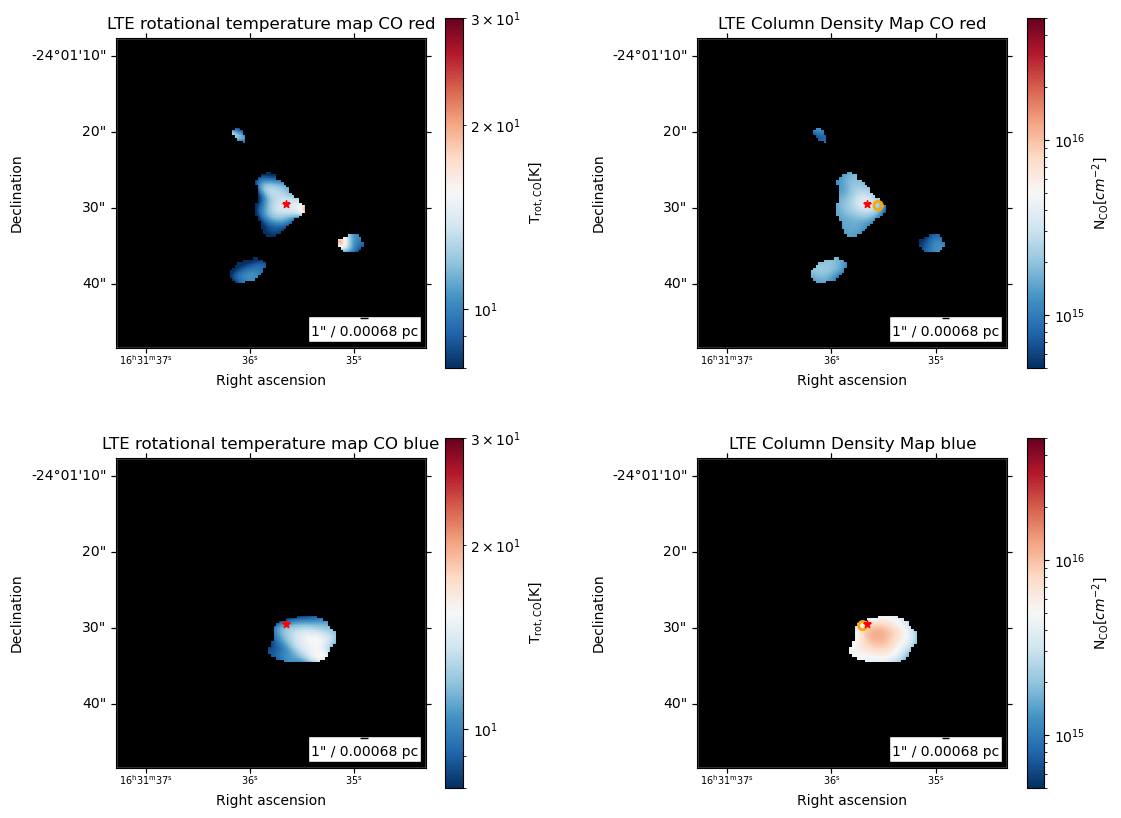

In [586]:
if source_name=='Oph_12':
    norm_T = mpl.colors.LogNorm(vmin=3e0, vmax=3.5e1)
    norm_d = mpl.colors.LogNorm(vmin=1e14, vmax=1e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_26':
    norm_T = mpl.colors.LogNorm(vmin=5e0, vmax=4.5e1)
    norm_d = mpl.colors.LogNorm(vmin=1e15, vmax=5e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_27':
    norm_T = mpl.colors.LogNorm(vmin=5e0, vmax=5e1)
    norm_d = mpl.colors.LogNorm(vmin=1e15, vmax=5e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_29':
    norm_T = mpl.colors.LogNorm(vmin=5e0, vmax=6e1)
    norm_d = mpl.colors.LogNorm(vmin=2e14, vmax=1e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_31':
    norm_T = mpl.colors.LogNorm(vmin=2e0, vmax=5e1)
    norm_d = mpl.colors.LogNorm(vmin=5e13, vmax=1e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_34':
    norm_T = mpl.colors.LogNorm(vmin=8e0, vmax=3e1)
    norm_d = mpl.colors.LogNorm(vmin=5e14, vmax=5e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

elif source_name=='Oph_39':
    norm_T = mpl.colors.LogNorm(vmin=1e1, vmax=4e1)
    norm_d = mpl.colors.LogNorm(vmin=1e15, vmax=5e16)
    sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
    sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)



#Do the plottomg pf rotational temperature and total column density
if source_name=='Oph_34':
    fig, ax = plt.subplots(2,2, figsize=(12.5,10), subplot_kw={'projection': wcs_B3_red}) #size horizontal: 20,9.5
else:
    fig, ax = plt.subplots(2,2, figsize=(12.5,10), subplot_kw={'projection': wcs_B7_red}) #size horizontal: 20,9.5

#temp red
ax[0,0].imshow(Tk_CO_red_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_T)
ax[0,0].set_facecolor('black')
ax[0,0].set_title('LTE rotational temperature map CO red')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
v.add_beam(ax=ax[0,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
# ax[0,0].scatter(385,450, facecolors='none', edgecolors='orange', linewidth=2) #bad
# ax[0,0].scatter(350,450, facecolors='none', edgecolors='black', linewidth=2) #good
ax[0,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc", frame=True, pad=0.2)
fig.colorbar(mappable=sm_T, ax=ax[0,0], label=r'T$_{\mathrm{rot,CO}}$[K]')

#temp blue
ax[1,0].imshow(Tk_CO_blue_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_T)
ax[1,0].set_facecolor('black')
ax[1,0].set_title('LTE rotational temperature map CO blue')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
v.add_beam(ax=ax[1,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc", frame=True, pad=0.2)
fig.colorbar(mappable=sm_T, ax=ax[1,0], label=r'T$_{\mathrm{rot,CO}}$[K]')

#coldens red
ax[0,1].imshow(N_tot_red_behaved, origin='lower', cmap='RdBu_r', norm=norm_d)
ax[0,1].set_facecolor('black')
ax[0,1].set_title('LTE Column Density Map CO red')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
v.add_beam(ax=ax[0,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc", frame=True, pad=0.2)
fig.colorbar(mappable=sm_d, ax=ax[0,1], label=r'N$_{\mathrm{CO}}[cm^{-2}]$')

#coldens blue
ax[1,1].imshow(N_tot_blue_behaved, origin='lower', cmap='RdBu_r', norm=norm_d)
ax[1,1].set_facecolor('black')
ax[1,1].set_title('LTE Column Density Map blue')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
v.add_beam(ax=ax[1,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc", frame=True, pad=0.2)
fig.colorbar(mappable=sm_d, ax=ax[1,1], label=r'N$_{\mathrm{CO}}[cm^{-2}]$')


if source_name == 'Oph_12' or source_name == 'Oph_26' or source_name == 'Oph_27' or source_name == 'Oph_29' or source_name == 'Oph_31' or source_name == 'Oph_39':
    ax[0,0].set_xlim(15,85)
    ax[0,0].set_ylim(15,85)
    ax[0,1].set_xlim(15,85)
    ax[0,1].set_ylim(15,85)

    ax[1,0].set_xlim(15,85)
    ax[1,0].set_ylim(15,85)
    ax[1,1].set_xlim(15,85)
    ax[1,1].set_ylim(15,85)


if source_name == 'Oph_34': 
    ax[0,1].scatter(150,135, facecolors='none', edgecolors='orange', linewidth=2) 
    ax[1,1].scatter(144,135, facecolors='none', edgecolors='orange', linewidth=2) 
    
    ax[0,0].set_xlim(80,200)
    ax[0,0].set_ylim(80,200)
    ax[0,1].set_xlim(80,200)
    ax[0,1].set_ylim(80,200)

    ax[1,0].set_xlim(80,200)
    ax[1,0].set_ylim(80,200)
    ax[1,1].set_xlim(80,200)
    ax[1,1].set_ylim(80,200)

ax[0,0].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[0,0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores', zorder=100)
ax[0,1].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[0,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,0].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[1,0].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,1].scatter(twomass_cores_coords.ra, twomass_cores_coords.dec, transform=ax[1,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')


plt.subplots_adjust(wspace=0.5)
plt.savefig(path+'plots/LTE_tempmaps_vertical.png', dpi=500, bbox_inches='tight')

In [587]:
print('The minimum temp in behaved red',np.min(Tk_CO_red_behaved[Tk_CO_red_behaved>0.]))
print('The maximum temp in behaved red',np.max(Tk_CO_red_behaved[Tk_CO_red_behaved>0.]))

print('The minimum temp in behaved blue',np.min(Tk_CO_blue_behaved[Tk_CO_blue_behaved>0.]))
print('The maximum temp in behaved blue',np.max(Tk_CO_blue_behaved[Tk_CO_blue_behaved>0.]))



The minimum temp in behaved red 6.785489785454294 K
The maximum temp in behaved red 19.282556836737736 K
The minimum temp in behaved blue 7.789611212693772 K
The maximum temp in behaved blue 15.728277000720007 K


14.68524301726139 K pm 11.395349768520166 K
2347776246999764.0
13.796812339589303 K pm 8.775384710289092 K
5595473595386645.0


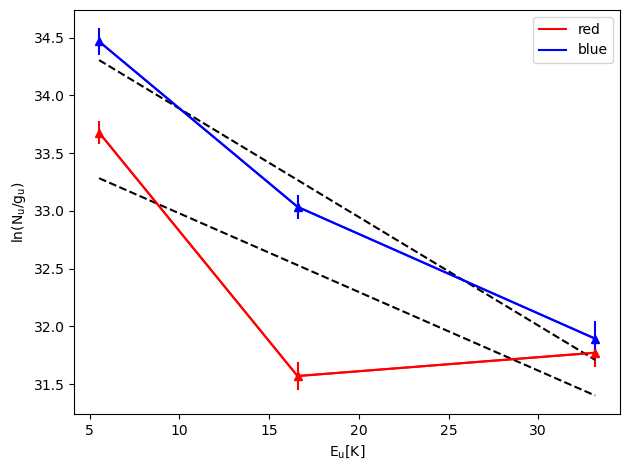

In [589]:
plt.figure()
if source_name=='Oph_34':
    rot_x, rot_y = 150,135 #I do not 100% understand how or why this works, but it does. You need to flip them somehow.
plt.errorbar(E_values,ln_Nu_gu_red[:,rot_y,rot_x],yerr =ln_Nu_gu_red_err[:, rot_y, rot_x],color='red',marker='^',zorder=1)
plt.plot(E_values,ln_Nu_gu_red[:,rot_y,rot_x], color='red',zorder=1, label='red')
print(T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
print(N_tot_red_behaved[rot_y, rot_x]) #for slicing you need to do (y,x)...
plt.plot(E_values, params_a_red[rot_y, rot_x] * E_values + params_b_red[rot_y, rot_x], color='black', linestyle='--', zorder=1)

if source_name=='Oph_34':
    rot_x, rot_y = 144,135 
    
print(T_red[rot_y, rot_x],'pm',e_T_red[rot_y, rot_x])
plt.errorbar(E_values,ln_Nu_gu_blue[:,rot_y, rot_x], color='blue',marker='^',zorder=1, yerr =ln_Nu_gu_blue_err[:,rot_y, rot_x])
plt.plot(E_values,ln_Nu_gu_blue[:,rot_y, rot_x], color='blue',zorder=1, label='blue')
print( N_tot_blue_behaved[rot_y, rot_x]) #for slicing you need to do (y,x)...
plt.plot(E_values, params_a_blue[rot_y, rot_x] * E_values + params_b_blue[rot_y, rot_x], color='black', linestyle='--', zorder=1)

plt.xlabel(r'E$_{\mathrm{u}}$[K]')
plt.ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')

plt.legend()

plt.tight_layout()
# plt.savefig(fname=path+'plots/rotdiagrams_2.pdf')

In [585]:
# #required to plot the colorbars
# norm_ratio = mpl.colors.LogNorm(vmin=1e-1, vmax=1e0)
# sm_ratio = cm.ScalarMappable(norm=norm_ratio, cmap=cmap)

# #trying to figure out why some spots disappear/are very high
# fig, ax = plt.subplots(1,2, figsize=(10,5), subplot_kw={'projection': wcs_B6_red}) #size horizontal: 20,9.5

# #ratio red
# ax[0].imshow(B6_red_clip/B7_red_clip, origin='lower', cmap='RdBu_r', norm=norm_ratio)
# ax[0].set_facecolor('black')
# ax[0].set_title('CO21/CO32 ratio red')
# ax[0].set_xlabel('Right ascension')
# ax[0].set_ylabel('Declination')
# v.add_beam(ax=ax[0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
# ax[0].set_xlim(300, 600)
# ax[0].set_ylim(300, 600)
# v.add_scalebar(ax[0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
# fig.colorbar(mappable=sm_ratio, ax=ax[0], label='ratio CO21/CO32')

# #ratio blue
# ax[1].imshow(B6_blue_clip/B7_blue_clip, origin='lower', cmap='RdBu_r', norm=norm_ratio)
# ax[1].set_facecolor('black')
# ax[1].set_title('CO21/CO32 ratio blue')
# ax[1].set_xlabel('Right ascension')
# ax[1].set_ylabel('Declination')
# v.add_beam(ax=ax[1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
# ax[1].set_xlim(400, 700)
# ax[1].set_ylim(300, 600)
# v.add_scalebar(ax[1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
# fig.colorbar(mappable=sm_ratio, ax=ax[1], label='ratio CO21/CO32')


# ax[0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0].get_transform('fk5'), s=30,
#            color='blue', marker='*', label='Hot cores')
# ax[1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1].get_transform('fk5'), s=30,
#            color='blue', marker='*', label='Hot cores')

# ax[0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0].get_transform('fk5'), s=30, 
#               color='red', marker='*', label='All cores', zorder=100)
# ax[1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1].get_transform('fk5'), s=30,
#                 color='red', marker='*', label='All cores')

# regions = Regions.read('/net/vdesk/data2/bach1/ballieux/master_project_2/data/high_mass_data/apertures_paths_pvdiagrams/G337.92_all', format='crtf')
# for region in regions:
#     pixel_region = region.to_pixel(wcs_B6_red)
#     pixel_region.plot(ax=ax[0], linewidth=1)
#     pixel_region.plot(ax=ax[1], linewidth=1)

# plt.subplots_adjust(wspace=0.5)
# plt.savefig(path+'plots/ratio_flux.png', bbox_inches='tight')